# Clique Cover Problem
Here we show how to solve the clique cover problem using OpenJij, [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/), and [JijModeling Transpiler](https://www.ref.documentation.jijzept.com/jijmodeling-transpiler/). This problem is also mentioned in 6.2. Clique Cover in [Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005).

## Overview of the Clique Cover Problem

The clique covering problem is to determine whether, given a graph and an integer $n$, the graph can be partitioned into $n$ cliques (complete graphs).

### Complete Graph

A complete graph is a graph whose two vertices are all adjacent to each other (not including loops or multiple edges).
We show two examples below.

![](../../../assets/clique_cover_01.png)

As mentioned, a vertex in a complete graph is adjacent to all other vertices. 
A complete undirected graph $G = (V, E)$ has ${}_V C_2 = \frac{1}{2} V(V-1)$ edges, which shows that the number of edges is equal to the number of combinations choosing two vertices from $V$.
Based on minimizing the difference in the number of edges from a complete graph, we describe a mathematical model for the clique cover problem.


### Binary Variable

We introduce a binary variable $x_{v, n}$ such that $x_{v, n}$ is 1 if the vertex $v$ belongs to the $n$th clique and 0 otherwise.

### Constraint
Each vertex can belong to only one clique, meaning that the graph is divided into $N$ cliques:

$$
\sum_{n=0}^{N-1} x_{v, c} = 1 \quad (\forall v \in V)
$$(1)

### Objective Function
Let us consider the $n$th subgraph $G (V_n, E_n)$.
The number of vertices is $V_n = \sum_v x_{v,n}$. 
If this subgraph is complete, the number of edges of this subgraph is $\frac{1}{2} V_n (V_n -1)$ from the previous discussion. 
The number of edges can actually be written as $\sum_{(uv) \in E_n} x_{u, n} x_{v, n}$.
The subgraph $G$ is neatly divided into cliques when the difference between these two approaches is zero.
Therefore, we set the objective function as follows:

$$
\mathbf{obj} 
= \sum_{n=0}^{N-1} \left\{ \frac{1}{2} \left( \sum_{v=0}^{V-1} x_{v, n} \right) \left( \sum_{v=0}^{V-1} x_{v, n} -1\right) - \sum_{(uv) \in E} x_{u, n} x_{v, n} \right\}
$$(2)

## Modeling by JijModeling

Next, we show an implementation using JijModeling.
We first define variables for the mathematical model described above.

### Variables

Let us define the variables used in expressions (1) and (2) as follows:

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', dim=2)
N = jm.Placeholder('N')
x = jm.Binary('x', shape=(V, N))
n = jm.Element('n', (0, N))
v = jm.Element('v', (0, V))
e = jm.Element('e', E)

`V=jm.Placeholder('V')` defines the number of vertices in the graph and `E=jm.Placeholder('E', dim=2)` defines the graph's edge set. `N=jm.Placeholder('N')` determines how many cliques the graph is divided into, and `V, N` is used to define the binary variable $x_{v, n}$ as `x=jm.Binary('x', shape=(V, N))`.
`n, v` is the variable used to index the binary variable, and `e` is the variable for the edge.
`e[0], e[1]` are the vertices located at both ends of edge `e`, which makes $(uv) = (e[0] e[1])$.

### Constraints

Let us implement the constraint in expression (1).

In [6]:
# set problem
problem = jm.Problem('Clique Cover')
# set one-hot constraint: each vertex has only one color
problem += jm.Constraint('color', x[v, :]==1, forall=v)

`x[v, :]` implements `Sum(n, x[v, n])` in a concise way.

### Objective Function

Let us implement the objective function of expression (2).

In [7]:
# set objective function: minimize the difference in the number of edges from complete graph
clique = x[:, n] * (x[:, n]-1) / 2
num_e = jm.Sum(e, x[e[0], n]*x[e[1], n])
problem += jm.Sum(n, clique-num_e)
problem

With `clique`, we calculate the number of edges if the vertex had created a clique. The next `num_e` is the calculated number of edges that the vertex has. Finally, the sum of the differences is added as the objective function.

### Instance

Here we prepare a graph using [NetworkX](https://networkx.org/).

In [9]:
import networkx as nx

# set the number of colors
inst_N = 3
# set empty graph
inst_G = nx.Graph()
# add edges
inst_E = [[0, 1], [1, 2], [0, 2], 
            [3, 4], [4, 5], [5, 6], [3, 6], [3, 5], [4, 6], 
            [7, 8], [8, 9], [7, 9], 
            [1, 3], [2, 6], [5, 7], [5, 9]]
inst_G.add_edges_from(inst_E)
# get the number of nodes
inst_V = list(inst_G.nodes)
num_V = len(inst_V)
instance_data = {'N': inst_N, 'V': num_V, 'E': inst_E}

The graph set up by this instance is as follows.

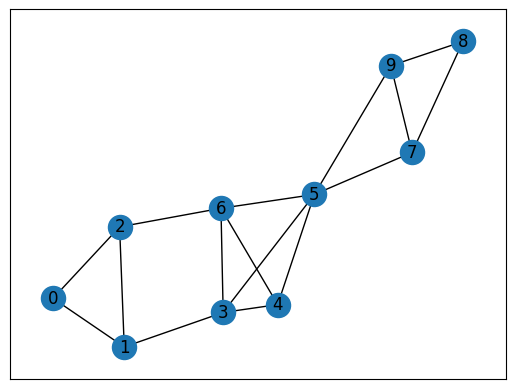

In [10]:
import matplotlib.pyplot as plt

nx.draw_networkx(inst_G, with_labels=True)
plt.show()

This graph consists of three cliques (0, 1, 2), (3, 4, 5, 6), and(7, 8, 9).

### Undetermined Multiplier

This problem has one constraint, and we need to set the weight of that constraint.
We will set it to match the name we gave in the `Constraint` part earlier using a dictionary type.

In [11]:
# set multipliers
lam1 = 1.1
multipliers = {'color': lam1}

### Conversion to PyQUBO by JijModeling Transpiler

JijModeling has executed all the implementations so far.
By converting this to [PyQUBO](https://pyqubo.readthedocs.io/en/latest/), it is possible to perform combinatorial optimization calculations using OpenJij and other solvers.

In [12]:
from jijmodeling.transpiler.pyqubo import to_pyqubo

# convert to pyqubo
pyq_model, pyq_chache = to_pyqubo(problem, instance_data, {})
qubo, bias = pyq_model.compile().to_qubo(feed_dict=multipliers)

The PyQUBO model is created by `to_pyqubo` with the `problem` created by JijModeling and the `instance_data` we set to a value as arguments.
Next, we compile it into a QUBO model that can be computed by OpenJij or other solver.

### Optimization by OpenJij

This time, we will use OpenJij's simulated annealing to solve the optimization problem.
We set the `SASampler` and input the QUBO into that sampler to get the result of the calculation.

In [13]:
import openjij as oj

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(qubo, num_reads=100)

### Decoding and Displaying the Solution

Decode the returned results to facilitate analysis.

In [14]:
# decode solution
result = pyq_chache.decode(response)

From the result thus obtained, let us visualize the graph.
By using `result.feasible()`, only feasible solutions can be extracted.
From here, the process of coloring the vertices for each clique is performed.

Objective: 0.0


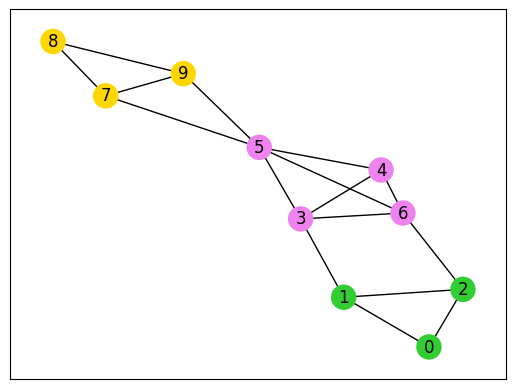

In [18]:
# extract feasible solution
feasible = result.feasible()
if feasible.evaluation.objective == []:
    print('No feasible solution found ...')
else:
    print("Objective: "+str(feasible.evaluation.objective[0]))
    # get indices of x = 1
    indices, _, _ = feasible.record.solution['x'][0]
    # get vertex number and color
    vertices, colors = indices
    # sort lists by vertex number
    zip_lists = zip(vertices, colors)
    zip_sort = sorted(zip_lists)
    sorted_vertices, sorted_colors = zip(*zip_sort)
    # initialize vertex color list
    node_colors = [-1] * len(vertices)
    # set color list for visualization
    colorlist = ['gold', 'violet', 'limegreen']    
    # set vertex color list
    for i, j in zip(sorted_vertices, sorted_colors):
        node_colors[i] = colorlist[j]
    # make figure
    fig = plt.figure()
    nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
    plt.show()

It is correctly divided into cliques.
We recommend you try more complex graphs.